In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# from plotly.subplots import make_subplots
# import plotly.graph_objects as go
# import plotly.express as px
from scipy.integrate import solve_ivp 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits import mplot3d
import string
import networkx as nx

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Number of individuals in the community
N = 10000

# Number of communities and edges added per epoch
M = 6

# Start and End epochs
t0, tf = 0, 3000

# Number of timesteps
Nt = 3000

# Time series
t = np.linspace(t0, tf, Nt + 1)

# Differential equation params
sigma = 0.1
a0 = 0.01
a1 = 0.0001
gamma = 0.07
zeta = 0.02
chi = 0.1

# Setup for the beta slider
beta_min = 0
beta_max = 0.06

beta_steps = 10

# Coupling strength steps
epsilon_steps = 50

# Patch steps
l_steps = M - 1

# Generating all the lists
epsilon_list = np.logspace(-5, 1, epsilon_steps, base=10)
l_list = np.arange(1, M)
beta_list = np.linspace(beta_min, beta_max, beta_steps)

In [3]:
# Making a complete graph with 4 Nodes
adj_mat = np.full((M, M), 1, dtype="int").reshape(M, M)
# graph = nx.erdos_renyi_graph(M, 0.3, seed=None, directed=False)
# adj_mat = nx.to_numpy_array(graph).reshape(M, M)

# Making the degree list for each node (di = M-1 here)
degree_list = np.sum(adj_mat, axis=0).reshape(M, 1)

# Dividing the adjacency matrix by rowsum
row_sums= np.sum(adj_mat, axis=1)
adj_mat_normalised = (adj_mat/row_sums[:,np.newaxis]).reshape(M, M)

In [4]:
def get_degree_counts(n : int, adj_mat):
    freq_map = np.zeros(n) # degree -> count
    for i in range(n):
        num_neighbours = int(np.sum(adj_mat[i]))
        freq_map[num_neighbours] += 1
    return np.array(freq_map)

In [5]:
# Returns a probabiltity distribution
# that is based on degree, pi = di/total(di) 
def degree_centrality(adj_mat, patches_to_apply):
    # Get degree_list
    degree_list = np.sum(adj_mat, axis=0, dtype="float")
    # Replace with zero in the range [patches_to_apply, len(adj_list))
    np.put(degree_list, np.arange(patches_to_apply, M), 0)

    return degree_list / np.sum(degree_list, dtype="float")

In [6]:
# Returns a uniform probability distribution
def const_prob(adj_mat, patches_to_apply):
    m = int(len(adj_mat)) # Number of communities

    # each node as probability as 1/patches_to_apply
    retval = np.full(m, 1, dtype="float") / float(patches_to_apply)

    # Replace with zero in the range [patches_to_apply, len(adj_list))
    np.put(retval, np.arange(patches_to_apply, M), 0)

    return retval

In [7]:
# Returns node wise distribution strategy for test kits
def g_val(a1, K, prob_distri_test_kit):
    return a1 * K * prob_distri_test_kit

In [8]:
def migration_term(adj_mat, adj_mat_normalised, compartment):
    # Getting the Amn x Sm term
    retval = np.dot(adj_mat_normalised, compartment).reshape(int(len(compartment)), 1)
    
    # Returning the migration amount
    return (retval - compartment)

In [9]:
def ODE_multi_node_with_testkit(t, X_flat, beta, adj_mat, adj_mat_normalised, degree_list, shape_X, epsilon, num_patches, l, gamma, sigma, zeta, chi, a0, a1):
    # Unraveling the X_flat vector
    X = X_flat.reshape(shape_X) 
    S, E, I, H, R, K = X
    
    # Reshaping into patchesx1 matrix from rank-1 array
    S = S.reshape(num_patches, 1)
    E = E.reshape(num_patches, 1)
    I = I.reshape(num_patches, 1)
    H = H.reshape(num_patches, 1)
    R = R.reshape(num_patches, 1)
    
    # Warning : K is a number NOT a list
    # So, we will turn it into a "fake" list by repeating it num_patches times
    K = K.reshape(num_patches, 1)
    
    # We are using degree centrality based test kit distribution
    g = g_val(a1, K[0], degree_centrality(adj_mat, l).reshape(num_patches, 1))

    # Reshaping into num_patches x 1 matrix
    g = g.reshape(num_patches, 1)
    
    # Obtaining the total population of each patch
    tot_pop = S + E + I + H + R
    
    # Hospitalization param
    alpha = a0 + g
    
    S_migration = ((epsilon) * migration_term(adj_mat, adj_mat_normalised, S)).reshape(num_patches, 1)
    E_migration = ((epsilon) * migration_term(adj_mat, adj_mat_normalised, E)).reshape(num_patches, 1)
    I_migration = ((epsilon) * migration_term(adj_mat, adj_mat_normalised, I)).reshape(num_patches, 1)
    R_migration = ((epsilon) * migration_term(adj_mat, adj_mat_normalised, R)).reshape(num_patches, 1)
    
    # Find the derivatives list, broadcasting coming in clutch now
    dSdt = (np.divide(-(beta * S * I), tot_pop)) +  S_migration
    dEdt = (np.divide((beta * S * I), tot_pop)) - (sigma * E) + E_migration
    dIdt = (sigma * E) -  (alpha * I) + I_migration
    dHdt = (alpha * I) - (gamma * H)
    dRdt = (gamma * H) + R_migration
    dKdt = (zeta * np.full(num_patches, np.sum(I)).reshape(num_patches, 1)) - (chi * K)
    
    # Reshape the derivatives list for good measure
    dSdt = dSdt.reshape(num_patches, 1)
    dEdt = dEdt.reshape(num_patches, 1)
    dIdt = dIdt.reshape(num_patches, 1)
    dHdt = dHdt.reshape(num_patches, 1)
    dRdt = dRdt.reshape(num_patches, 1)
    dKdt = dKdt.reshape(num_patches, 1)
        
    derivs =  np.array([dSdt, dEdt, dIdt, dHdt, dRdt, dKdt])
    
    return derivs.ravel()

def ODE_multi_node_without_testkit(t, X_flat, beta, adj_mat, adj_mat_normalised, degree_list, shape_X, epsilon, num_patches, l, gamma, sigma, zeta, chi, a0, a1):
    return ODE_multi_node_with_testkit(t, X_flat, beta, adj_mat, adj_mat_normalised, degree_list, shape_X, epsilon, num_patches, l, gamma, sigma, zeta, chi, a0, 0)

In [10]:
def solver(adj_mat, adj_mat_normalised, degree_list, M, beta, ODE_func, E0, epsilon, num_patches, l):
    # Initial conditions for given beta
    I0, H0, R0, K0 = np.zeros(M), np.zeros(M), np.zeros(M), np.zeros(M)

    # Mandatory reshaping, for safety
    E0 = E0.reshape(M, 1)
    I0 = I0.reshape(M, 1)
    H0 = H0.reshape(M, 1)
    R0 = R0.reshape(M, 1)
    K0 = K0.reshape(M, 1)
    
    # Getting the susceptibles
    # [TBX : This makes N*M susceptibles by broadcasting]
    Total_population = np.full(M, N).reshape(M, 1)
    S0 = Total_population - E0 - I0 - H0 - R0
    S0 = S0.reshape(M, 1)

    # Making the state vector
    X0 = np.array([S0, E0, I0, H0, R0, K0])

    # Ravel the X vector temporarily
    shape_X = X0.shape
    X_flat = X0.ravel()

    # Solving the initial value problem
    solved_ivp = solve_ivp(ODE_func, (t0, tf), X_flat, args=(beta, adj_mat, adj_mat_normalised, degree_list, shape_X, epsilon, num_patches, l, gamma, sigma, zeta, chi, a0, a1), t_eval=t)

    # Returning the raw solved ivp data for plotting
    # solved_ivp.y.reshape(6, M, Nt+1)
    return solved_ivp

In [11]:
# X, Y and Z with testkits
x_with_testkits = np.array([]) 
y_with_testkits = np.array([])
z_with_testkits_mean = np.array([])

# X, Y and Z without testkits
x_without_testkits = np.array([])
y_without_testkits = np.array([])
z_without_testkits_mean = np.array([])

# Infection values for each community
I_vals_epsilon = []

l_value = 3

# Initial condition
custom_E0 = np.random.randint(1, 750, size=(M, 1))

for epsilon_value in epsilon_list:    
    # Solving the IVP using our solver function
    solved_ivp = solver(adj_mat, adj_mat_normalised, degree_list, M, 0.03, ODE_multi_node_with_testkit, custom_E0, epsilon_value, M, l_value)

    # Obtaining the shape we need to realize the y values
    reshape_vals = (6, M, solved_ivp.y.shape[1])

    # Getting the y value reshaped
    jffy = solved_ivp.y.reshape(reshape_vals)[2]

    # Obtaining the Infection values for each communities
    I_vals = (solved_ivp.y.reshape(6, M, reshape_vals[2])[2]).reshape(M, reshape_vals[2])

    # Normalize the I_vals
    I_vals_norm =  np.divide(I_vals, N)

    # Adding the infection trend to the list
    I_vals_epsilon.append(I_vals_norm)

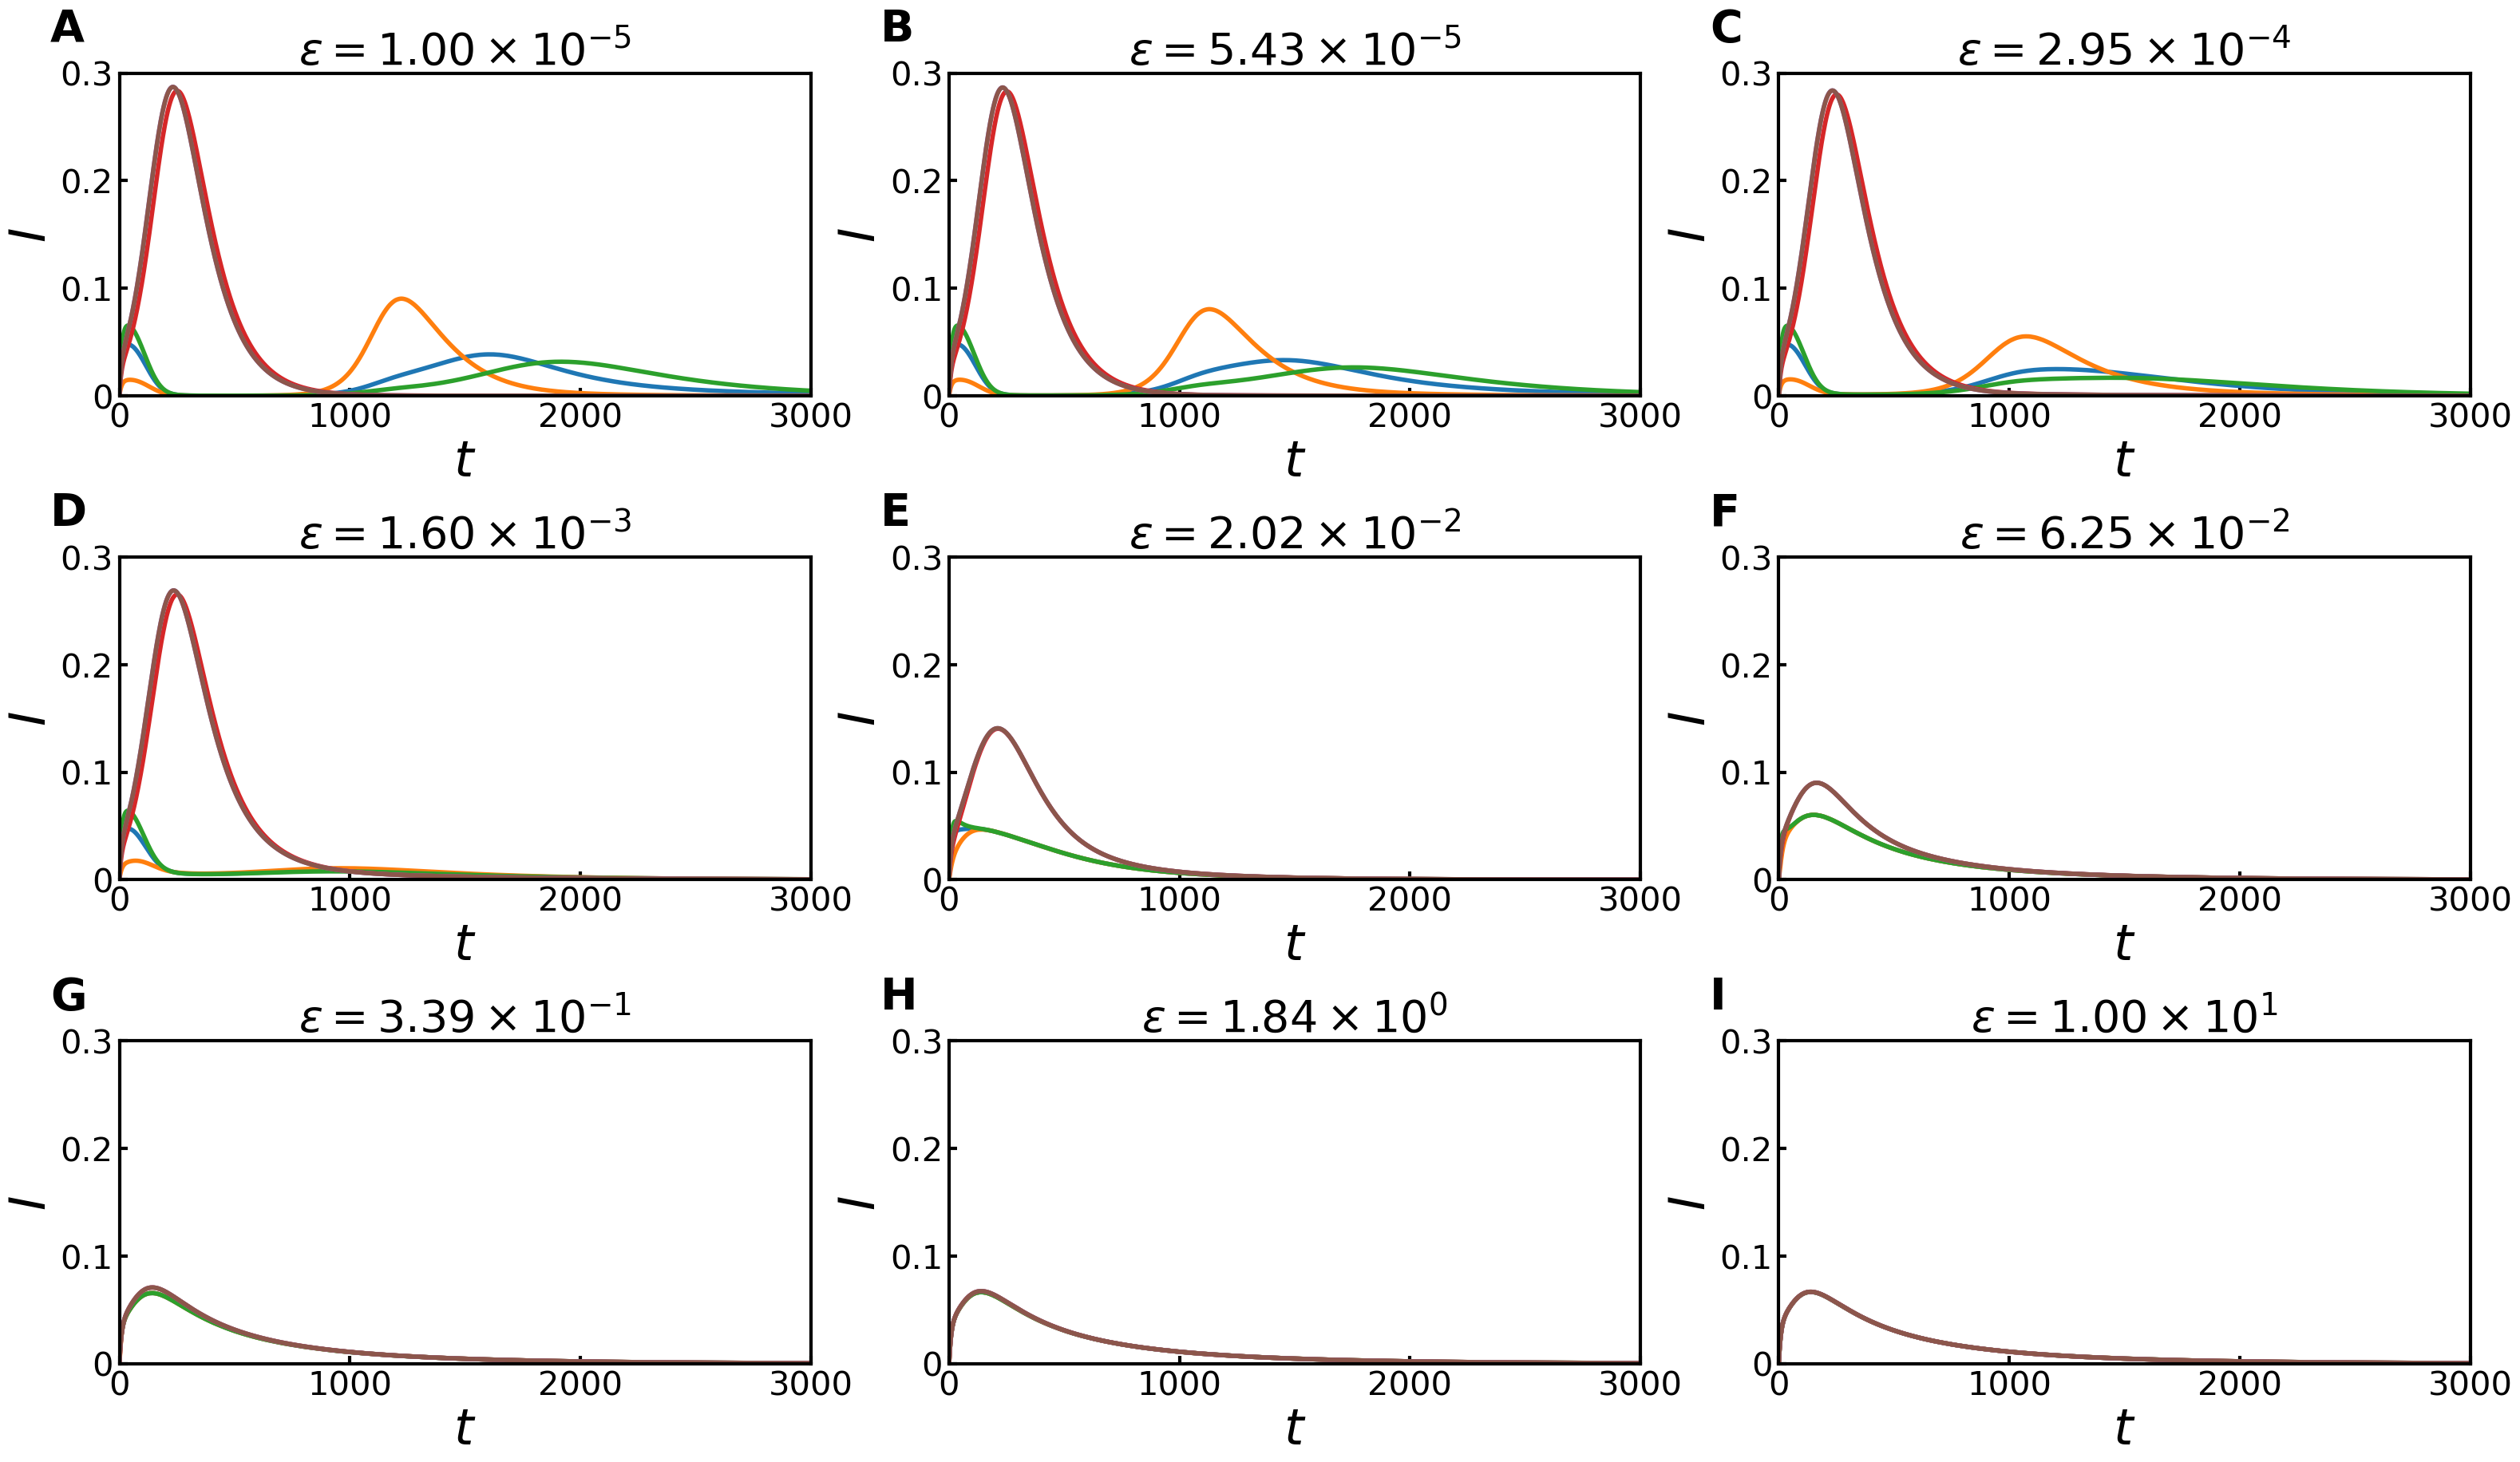

In [12]:
with plt.style.context('seaborn-paper'):
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(38, 21))
    plt.subplots_adjust(hspace=0.5, wspace=0.2)

    vals_to_plot = [0, 6, 12, 18, 27, 31, 37, 43, 49]

    plt_idx = 0
    for community_idx in vals_to_plot:
        i, j = plt_idx//3, plt_idx%3

        for I_community in I_vals_epsilon[community_idx]:
            im = axs[i][j].plot(I_community, linewidth=4)

        epsilon_value_scientific = '%.2E' % epsilon_list[community_idx]
        epsilon_value_scientific = epsilon_value_scientific.split('E')
        epsilon_value_scientific[1] = str(int(epsilon_value_scientific[1]))
        axs[i][j].set_title(f'$\epsilon = {epsilon_value_scientific[0]} ' + r'\times 10^{' + epsilon_value_scientific[1] + r'}$', fontsize=40)
        axs[i][j].set_ylabel('$I$', fontsize=45)
        axs[i][j].set_xlabel('$t$', fontsize=45)
        axs[i][j].set_xlim([0, Nt])
        axs[i][j].set_ylim([0, 0.3])

        axs[i][j].tick_params(direction= 'in', length=7,width=3)
        for axis in ['top','bottom','left','right']:
            axs[i][j].spines[axis].set_linewidth(3)
    #         axs[i][j].spines[axis].set_zorder(0)

        x_ticks = [i for i in range(0, Nt + 1, 1000)]
    #     y_ticks = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
        y_ticks = [0, 0.10, 0.20, 0.30]
#         y_ticks = [0, 0.5, 1.0, 1.5, 2.0]


        axs[i][j].set_xticks([float(x_tick) for x_tick in x_ticks],
                             [str(x_tick) for x_tick in x_ticks],
                            fontsize=30)
        axs[i][j].set_yticks([float(y_tick) for y_tick in y_ticks],
                             [str(round(y_tick, 2)) for y_tick in y_ticks],
                            fontsize=30)

        axs[i][j].text(-0.1, 1.1, string.ascii_uppercase[plt_idx], transform=axs[i][j].transAxes, 
                size=40, weight='bold')

        plt_idx+=1

    fig.savefig('gradual_clustering_ER.svg', dpi=1200, bbox_inches='tight')
    # Infection curves for each community for 

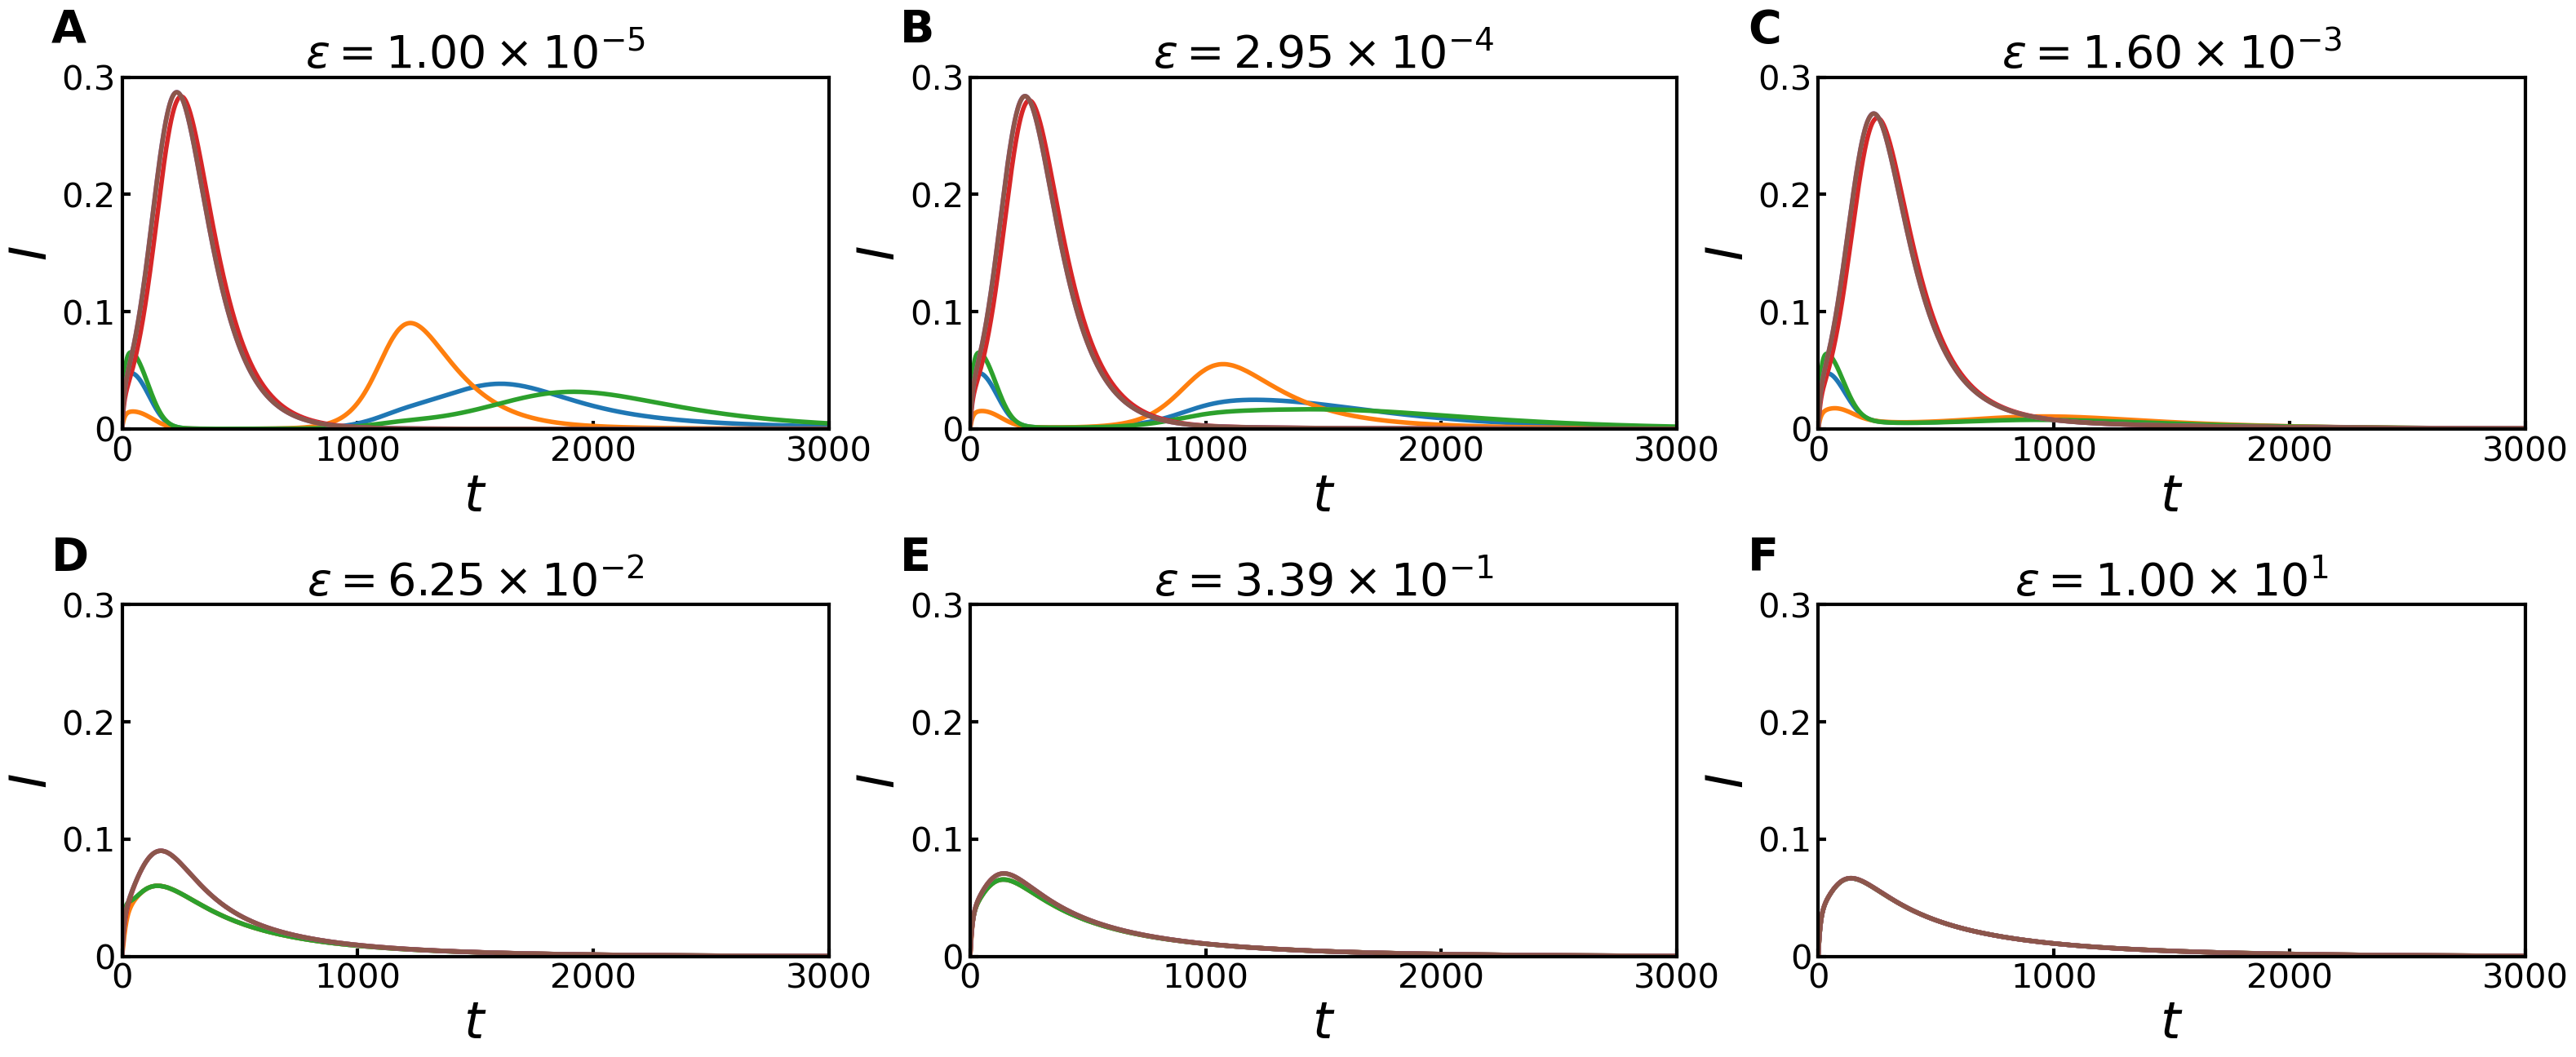

In [13]:
import matplotlib.pyplot as plt
import string

with plt.style.context('seaborn-paper'):
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(38, 14))
    plt.subplots_adjust(hspace=0.5, wspace=0.2)
    
    # vals_to_plot = [0, 6, 12, 18, 27, 31, 37, 43, 49]
    vals_to_plot = [0, 12, 18, 31, 37, 49]  # Updated to 6 values for 2x3 grid
#     epsilon_list = [epsilon_list[0], epsilon_list[2], 
#                     epsilon_list[3], epsilon_list[5], 
#                     epsilon_list[6], epsilon_list[8]]

    plt_idx = 0
    for community_idx in vals_to_plot:
        i, j = plt_idx // 3, plt_idx % 3

        for I_community in I_vals_epsilon[community_idx]:
            im = axs[i][j].plot(I_community, linewidth=4)

        epsilon_value_scientific = '%.2E' % epsilon_list[community_idx]
        epsilon_value_scientific = epsilon_value_scientific.split('E')
        epsilon_value_scientific[1] = str(int(epsilon_value_scientific[1]))
        axs[i][j].set_title(f'$\epsilon = {epsilon_value_scientific[0]} ' + r'\times 10^{' + epsilon_value_scientific[1] + r'}$', fontsize=40)
        axs[i][j].set_ylabel('$I$', fontsize=45)
        axs[i][j].set_xlabel('$t$', fontsize=45)
        axs[i][j].set_xlim([0, Nt])
        axs[i][j].set_ylim([0, 0.3])

        axs[i][j].tick_params(direction='in', length=7, width=3)
        for axis in ['top', 'bottom', 'left', 'right']:
            axs[i][j].spines[axis].set_linewidth(3)

        x_ticks = [i for i in range(0, Nt + 1, 1000)]
        y_ticks = [0, 0.10, 0.20, 0.30]

        axs[i][j].set_xticks(x_ticks)
        axs[i][j].set_xticklabels([str(x_tick) for x_tick in x_ticks], fontsize=30)
        axs[i][j].set_yticks(y_ticks)
        axs[i][j].set_yticklabels([str(round(y_tick, 2)) for y_tick in y_ticks], fontsize=30)

        axs[i][j].text(-0.1, 1.1, string.ascii_uppercase[plt_idx], transform=axs[i][j].transAxes, 
                size=40, weight='bold')

        plt_idx += 1

    fig.savefig('gradual_clustering_complete.pdf', dpi=1200, bbox_inches='tight')


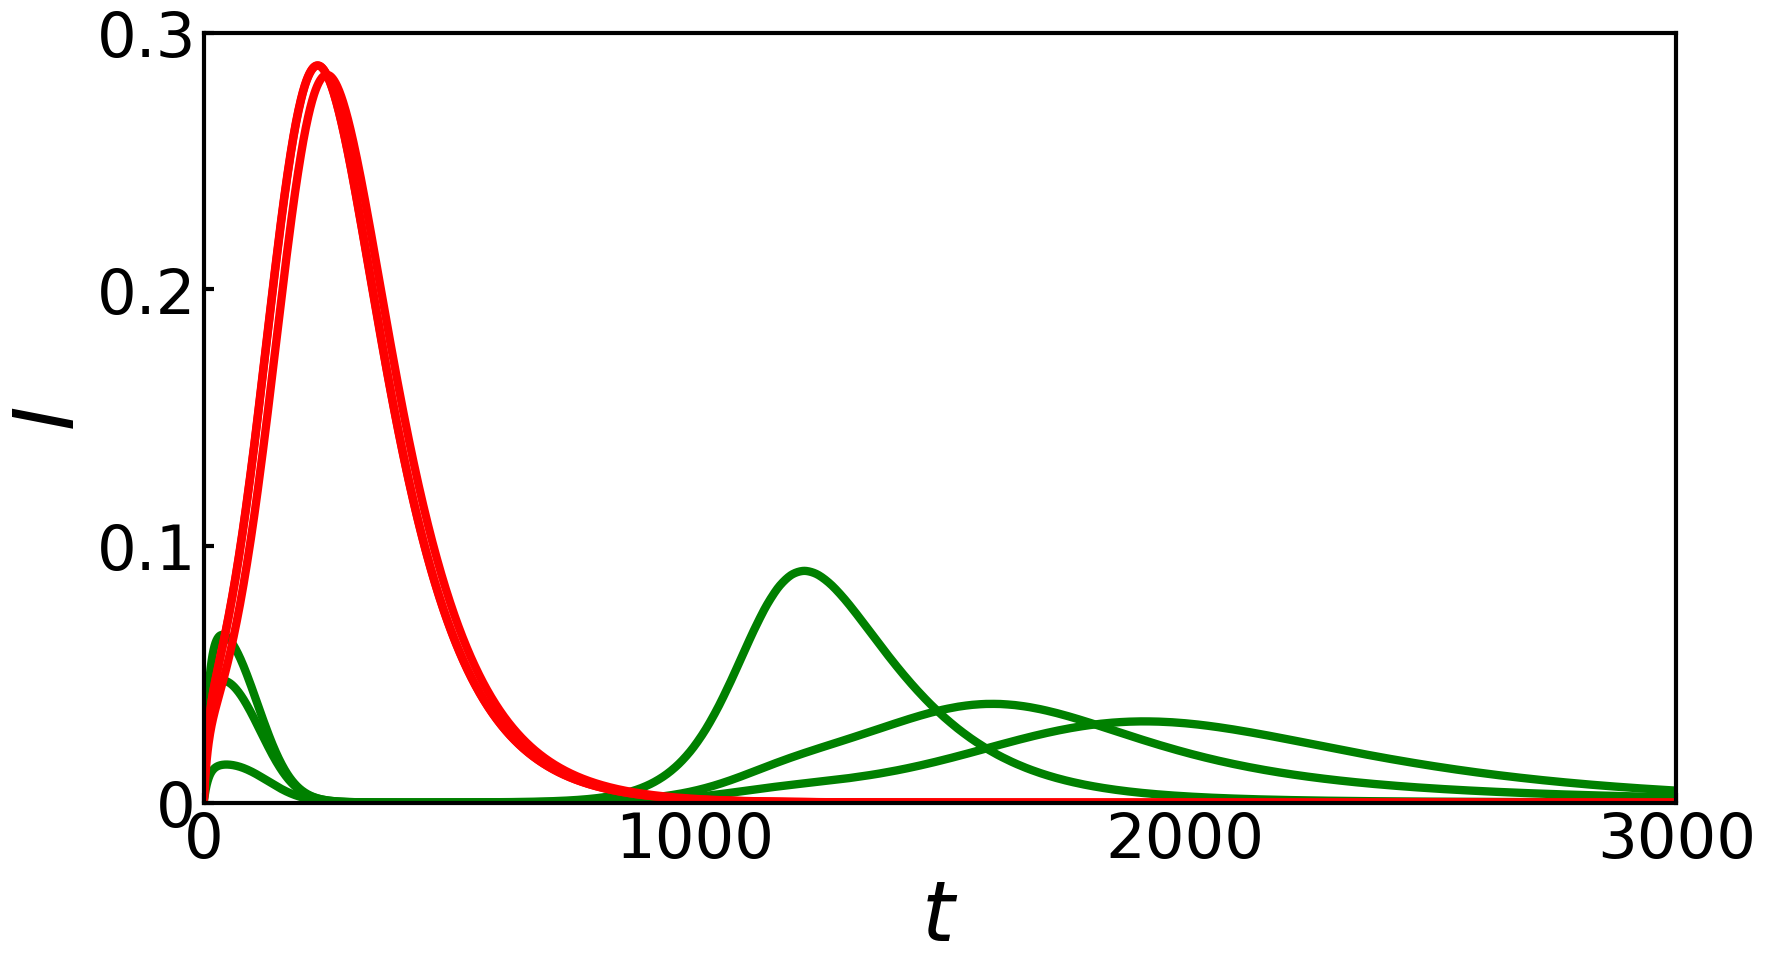

In [14]:
with plt.style.context('seaborn-paper'):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(19, 10))
    plt.subplots_adjust(hspace=0.5, wspace=0.2)
    # fig.tight_layout(pad=5.0)

    # fig.suptitle('Gradual clustering of infection curves with increasing $\epsilon$', fontsize=24)

#     vals_to_plot = [0, 9, 15, 20, 25, 30, 38, 49]
    colors = ['green', 'green', 'green', 'red', 'red', 'red']
    color_idx = 0
    vals_to_plot = [0, 6, 12, 18, 27, 31, 37, 43, 49]
#     vals_to_plot = [0, 1, 3, 4, 5, 6, 7, 8, 9]


    plt_idx = 0
    for community_idx in vals_to_plot:
        i, j = 0, 0

        for I_community in I_vals_epsilon[community_idx]:
            im = axs.plot(I_community, linewidth=6, color=colors[color_idx])
            color_idx += 1

        epsilon_value_scientific = '%.2E' % epsilon_list[community_idx]
        epsilon_value_scientific = epsilon_value_scientific.split('E')
        epsilon_value_scientific[1] = str(int(epsilon_value_scientific[1]))
#         axs.set_title(f'$\epsilon = {epsilon_value_scientific[0]} ' + r'\times 10^{' + epsilon_value_scientific[1] + r'}$', fontsize=40)
        axs.set_ylabel('$I$', fontsize=60)
        axs.set_xlabel('$t$', fontsize=60)
        axs.set_xlim([0, Nt])
        axs.set_ylim([0, 0.3])

        axs.tick_params(direction= 'in', length=7,width=3)
        for axis in ['top','bottom','left','right']:
            axs.spines[axis].set_linewidth(3)
    #         axs[i][j].spines[axis].set_zorder(0)

        x_ticks = [i for i in range(0, Nt + 1, 1000)]
    #     y_ticks = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
        y_ticks = [0, 0.10, 0.20, 0.30]
#         y_ticks = [0, 0.5, 1.0, 1.5, 2.0]


        axs.set_xticks([float(x_tick) for x_tick in x_ticks],
                             [str(x_tick) for x_tick in x_ticks],
                            fontsize=45)
        axs.set_yticks([float(y_tick) for y_tick in y_ticks],
                             [str(round(y_tick, 2)) for y_tick in y_ticks],
                            fontsize=45)

        plt_idx+=1
        
        break

    fig.savefig('gradual_clustering_A.svg', dpi=1200, bbox_inches='tight')
    # Infection curves for each community for 

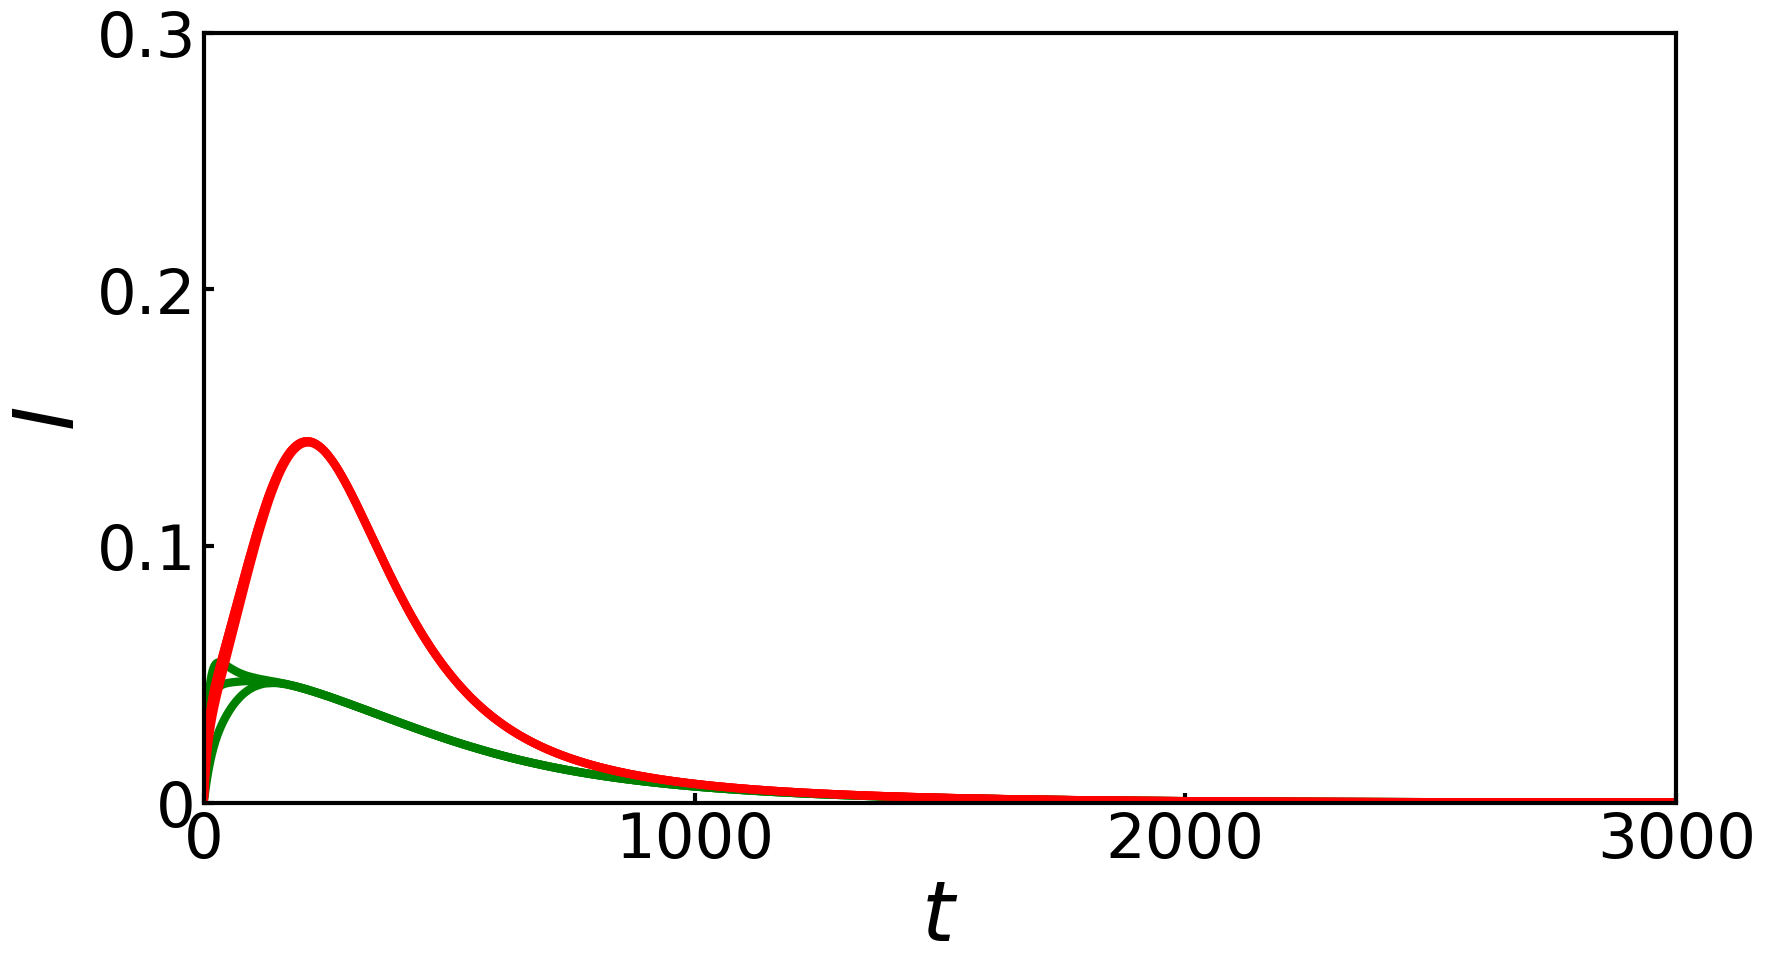

In [15]:
with plt.style.context('seaborn-paper'):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(19, 10))
    plt.subplots_adjust(hspace=0.5, wspace=0.2)

    vals_to_plot = [0, 6, 12, 18, 27, 31, 37, 43, 49]
    colors = ['green', 'green', 'green', 'red', 'red', 'red']
    color_idx = 0

    plt_idx = 0
    for community_idx in vals_to_plot[4:]:
        i, j = 0, 0

        for I_community in I_vals_epsilon[community_idx]:
            im = axs.plot(I_community, linewidth=6, color=colors[color_idx])
            color_idx += 1

        epsilon_value_scientific = '%.2E' % epsilon_list[community_idx]
        epsilon_value_scientific = epsilon_value_scientific.split('E')
        epsilon_value_scientific[1] = str(int(epsilon_value_scientific[1]))
        axs.set_ylabel('$I$', fontsize=60)
        axs.set_xlabel('$t$', fontsize=60)
        axs.set_xlim([0, Nt])
        axs.set_ylim([0, 0.3])

        axs.tick_params(direction='in', length=7, width=3)
        for axis in ['top', 'bottom', 'left', 'right']:
            axs.spines[axis].set_linewidth(3)

        x_ticks = [i for i in range(0, Nt + 1, 1000)]
        y_ticks = [0, 0.10, 0.20, 0.30]

        axs.set_xticks([float(x_tick) for x_tick in x_ticks],
                       [str(x_tick) for x_tick in x_ticks],
                       fontsize=45)
        axs.set_yticks([float(y_tick) for y_tick in y_ticks],
                       [str(round(y_tick, 2)) for y_tick in y_ticks],
                       fontsize=45)

        plt_idx += 1
        
        break

    fig.savefig('gradual_clustering_I.svg', dpi=1200, bbox_inches='tight')
